Thank you very much to this paper [Gatys et al](https://arxiv.org/pdf/1508.06576.pdf) and this [blogpost](https://harishnarayanan.org/writing/artistic-style-transfer/) by harishnaranayann. They really helped me to build neural style transfer

In [1]:
from __future__ import print_function
import time
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
# from scipy.misc import imsave

import imageio
# imageio.imwrite('filename.jpg', array)

#### Load and Process the content and style image

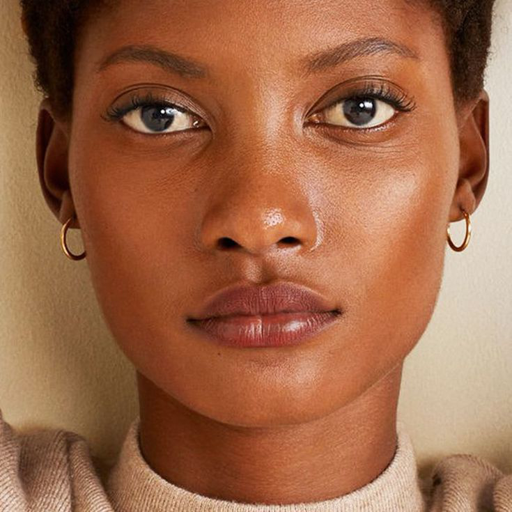

In [2]:
height = 512
width = 512

content_img = Image.open('./data/woman.jpg').resize((height, width))
style_img = Image.open('./data/art2.jpg').resize((height, width))
content_img

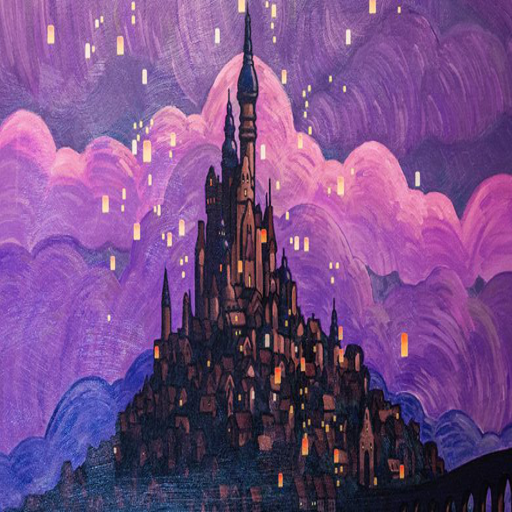

In [3]:
style_img

process images into form suitable for working on

In [4]:
content_arr = np.asarray(content_img, dtype='float32')
content_arr = np.expand_dims(content_arr, axis=0)
print(content_arr.shape)

style_arr = np.asarray(style_img, dtype='float32')
style_arr = np.expand_dims(style_arr, axis=0)
print(style_arr.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Processing the images according to what was done in VGG

1. Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).

In [5]:
content_arr[:, :, :, 0] -= 103.939
content_arr[:, :, :, 1] -= 116.779
content_arr[:, :, :, 2] -= 123.68
content_arr = content_arr[:, :, :, ::-1] # flip ordering from RGB to BRG

style_arr[:, :, :, 0] -= 103.939
style_arr[:, :, :, 1] -= 116.779
style_arr[:, :, :, 2] -= 123.68
style_arr = style_arr[:, :, :, ::-1] # flip ordering from RGB to BRG

create tensorflow variables of the content image and style image. Then create a placeholder to retain our content while applying our style. Then combine into a single image suitable for processing by VGG

In [6]:
content_img = backend.variable(content_arr)
style_img = backend.variable(style_arr)
combination_img = backend.placeholder((1, height, width, 3))

input_tensor = backend.concatenate([content_img, style_img, combination_img], axis=0)
input_tensor

<tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>

In [7]:
### DOWNLOADING VGG
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [8]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Identity:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Identity:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/Identity:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Identity:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Identity:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/Identity:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Identity:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Identity:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Identity:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/Identity:0' shape=(3, 64, 64, 256) dtyp

The style transfer problem can be posed as an optimization problem

In [9]:
### Generate aesthetically visual outputs
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [10]:
### INITIALIZE OUR LOSS FUNCTION
loss = backend.variable(0.)

Define our losses. Content loss is the euclidean distance between the feature representations of the content image and combination image at any layer we choose.
According to [Johnson et al](https://arxiv.org/abs/1603.08155), for a content loss, we should select block2_conv2

In [11]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_img_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + (content_weight * content_loss(content_img_features, combination_features))

In [12]:
### Style loss

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [14]:
feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

In [29]:
### This is to remove noise that will affect the image. Thereby encouraging spatial smoothness

def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss = loss + total_variation_weight * total_variation_loss(combination_img)

#### DEFINE OUR OPTIMIZERS

In [31]:
outputs = [loss]
with tf.GradientTape() as tape:
    tape.watch(combination_img)
    grads = tape.gradient(loss, combination_img)

# outputs = outputs + grads
grads

In [ ]:
f_outputs = backend.function([combination_img], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))